In [1]:
import sys, sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

print("Python:", sys.version)
print("pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)


Python: 3.10.18 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:08:55) [MSC v.1929 64 bit (AMD64)]
pandas: 2.3.2
scikit-learn: 1.7.1


In [3]:
df = pd.read_csv(r"C:\Users\chint\Downloads\student_prediction_dataset.csv")
print(df.shape)
df.head()


(600, 13)


,Name,RollNumber,ClassDivision,Subject,StudyHours,Attendance,PreviousScore,AssignmentsCompleted,SleepHours,Extracurriculars,ParentalSupport,TeacherRating,PredictedMarks
0,Harshita Yadav,23MLAI11,ML-AI A,Physics,3.3,79,87,60,8.8,4,3,7,49
1,Jaya Chintamreddy,23MLAI05,ML-AI A,Mathematics,1.0,56,51,78,6.6,4,3,9,92
2,Vivek Iyer,23MLAI29,ML-AI A,Chemistry,7.9,71,95,95,9.5,9,7,5,46
3,Tanya Dave,23MLAI17,ML-AI A,History,9.0,98,57,81,9.3,4,2,10,97
4,Omkar Singh,23MLAI25,ML-AI A,English,1.1,92,80,65,8.2,1,10,4,61


In [4]:
def to_performance(m):
    if m >= 85: return "Excellent"
    if m >= 70: return "Good"
    if m >= 50: return "Average"
    return "Poor"

df["Performance"] = df["PredictedMarks"].apply(to_performance)
df["Performance"].value_counts()


Performance
Average      190
Excellent    160
Good         149
Poor         101
Name: count, dtype: int64

In [5]:
num_features = [
    "StudyHours", "Attendance", "PreviousScore", "AssignmentsCompleted",
    "SleepHours", "Extracurriculars", "ParentalSupport", "TeacherRating"
]

cat_features = ["Subject", "ClassDivision"]

drop_cols = ["Name", "RollNumber", "PredictedMarks"]

X = df[num_features + cat_features].copy()
y = df["Performance"].copy()


In [6]:
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ],
    remainder="drop"
)


In [7]:
models = {
    "RandomForest": Pipeline([("prep", preprocessor),
                              ("clf", RandomForestClassifier(n_estimators=300, random_state=42))]),
    "kNN": Pipeline([("prep", preprocessor),
                     ("clf", KNeighborsClassifier(n_neighbors=7))]),
    "NaiveBayes": Pipeline([("prep", preprocessor),
                            ("clf", GaussianNB())]),
    "LogisticRegression": Pipeline([("prep", preprocessor),
                                    ("clf", LogisticRegression(max_iter=1000))]),
    "SVM": Pipeline([("prep", preprocessor),
                     ("clf", SVC(kernel="rbf", C=1.0, gamma="scale"))]),
    "NeuralNetwork": Pipeline([("prep", preprocessor),
                               ("clf", MLPClassifier(hidden_layer_sizes=(128,), activation="relu",
                                                     max_iter=1000, random_state=42))]),
    "GradientBoosting": Pipeline([("prep", preprocessor),
                                  ("clf", GradientBoostingClassifier(random_state=42))]),
}


In [8]:
def run_subset_experiment(size):
    # sample 'size' rows from dataset (stratify keeps class balance)
    df_sub = resample(df, n_samples=size, random_state=42, stratify=df["Performance"])
    
    X_sub = df_sub[num_features + cat_features]
    y_sub = df_sub["Performance"]

    X_train, X_test, y_train, y_test = train_test_split(
        X_sub, y_sub, test_size=0.2, random_state=42, stratify=y_sub
    )

    results = {}
    for name, pipe in models.items():
        pipe.fit(X_train, y_train)
        acc = accuracy_score(y_test, pipe.predict(X_test)) * 100
        results[name] = round(acc,2)
    return results


In [9]:
results_600 = run_subset_experiment(600)
results_400 = run_subset_experiment(400)
results_300 = run_subset_experiment(300)

# Combine into DataFrame
df_results = pd.DataFrame({
    "Model": results_600.keys(),
    "600 Rows": results_600.values(),
    "400 Rows": results_400.values(),
    "300 Rows": results_300.values(),
})

df_results


,Model,600 Rows,400 Rows,300 Rows
0,RandomForest,70.83,60.00,56.67
1,kNN,53.33,40.00,41.67
2,NaiveBayes,29.17,28.75,36.67
3,LogisticRegression,40.00,26.25,33.33
4,SVM,56.67,55.00,41.67
5,NeuralNetwork,73.33,57.50,60.00
6,GradientBoosting,75.00,55.00,58.33


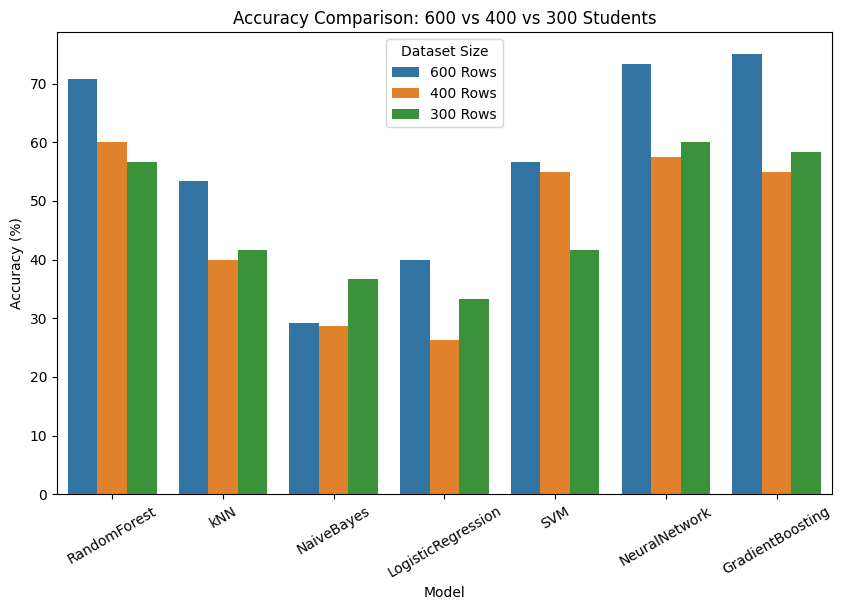

In [10]:
df_results_melt = df_results.melt(id_vars="Model", var_name="Dataset Size", value_name="Accuracy")

plt.figure(figsize=(10,6))
sns.barplot(x="Model", y="Accuracy", hue="Dataset Size", data=df_results_melt)
plt.title("Accuracy Comparison: 600 vs 400 vs 300 Students")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=30)
plt.show()
